Target
1.Determine the recognition accuracy (percentage of correctly classified data points) of KNN classifier on K=1,3,5
2.Determine the overall run time for computing the 1-nearest neighbor of every data in data2-test.dat.

In [1]:
import numpy as np
import numpy.linalg as la
import csv
import scipy.spatial.distance as ssd
import timeit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex
import pattrex.fitting as fit_rex
import pattrex.unit_circles as uc_rex


In [2]:
dt = np.dtype([('x', np.float), ('y', np.float), ('lable', np.float)])  # g is byte-string

data = np.loadtxt('data/data2-train.dat', dtype=dt, comments='#', delimiter=None)

x = np.array([d[0] for d in data])#x
y = np.array([d[1] for d in data])#y
lable = np.array([d[2] for d in data])#label

X = np.vstack((x, y, lable))  # data is going to be column-wise
X.shape

# split
X_pos, X_neg = pre_rex.split_data(X, True, 2, [1.0, -1.0])
print("Positive :", X_pos.shape[1], "; Negative :", X_neg.shape[1])


Positive : 128 ; Negative : 128


<IPython.core.display.Javascript object>


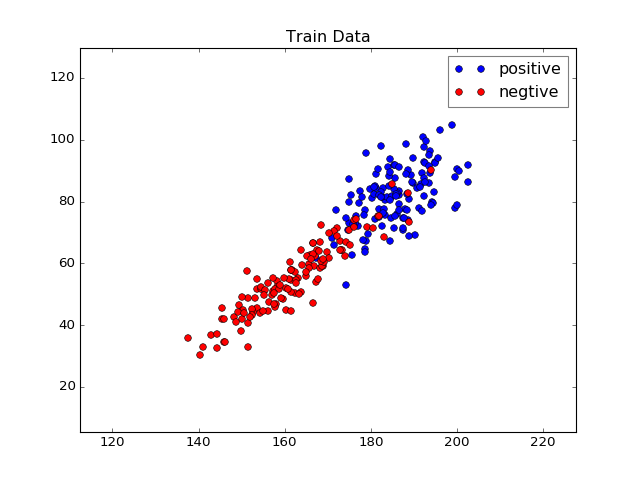

In [3]:
# plotting
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
X_ = np.vstack((x, y))  # only the measurements; data is col-wise
xmin, ymin = X_.min(axis=1)
xmax, ymax = X_.max(axis=1)

xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

plt_rex.plot2d(X_pos, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
              show=False, axs=axs, set_aspect_equal=False, plotlabel="positive")
plt_rex.plot2d(X_neg, colwise_data=True, hatch='ro', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, set_aspect_equal=False, 
               plotlabel="negtive", title="Train Data")

In [4]:
#1.Compute Nearest neighbor
#1.1 Naïve way: O(n^2) ( n*(n-1) ) for all
#https://www.researchgate.net/publication/283568278_NumPy_SciPy_Recipes_for_Data_Science_Computing_Nearest_Neighbors?channel=doi&linkId=563f695508ae45b5d28d2ea9&showFulltext=true
def nearest_neighbor_method1(X, q):
    m, n = X.shape
    minindx = 0
    mindist = np.inf
    for i in range(n):
        dist = la.norm(X[:,i] - q)
        if dist <= mindist:
            mindist = dist
            minindx = i
    return minindx

In [5]:
#1.2
def nearest_neighbor_method2(X, q):
    m, n = X.shape
    return np.argmin(np.sum((X-q.reshape(m,1))**2, axis=0))

In [6]:
#1.3
def nearest_neighbor_method3(X, q):
    X = X.T
    return np.argmin(np.sum((X - q)**2, axis=1))

In [7]:
#Method provided by the paper mentioned above
def k_nearest_neighbors(X, q, k):
    X = X.T
    sorted_inds = np.argsort(np.sum((X - q)**2, axis=1))
    return sorted_inds[:k]

In [8]:
def k_nearest_neighbors_par(X, q, k):
    X=X.T
    sorted_inds = np.argpartition(np.sum((X - q)**2, axis=1), k-1)
    return sorted_inds[:k]

In [9]:
#Or we could simply apply nearest_neighbor_mothodi k times, if k is relatively small comparing to size of X
def k_nearest_neighbors_smallk(X, q, k):
    inds=nearest_neighbor_method3(X, q)
    a_inds = np.array(inds)
    X=np.delete(X, inds, axis=1)
    for i in range(k-1):
        inds=nearest_neighbor_method2(X, q)
        a_inds=np.append(a_inds,inds)#remember to assign a pointer to new array. the return value is a pointer
        if i!=k-1:
            X=np.delete(X, inds, axis=1)
    return a_inds

In [10]:
#Test
if False:
    q = np.array([170, 66])
#     X = np.random.rand(2, 250)
    # print(X[:])
    # print(X_)
    # inds = k_nearest_neighbors_smallk(X_, q, 3)
    sorted_inds=nearest_neighbor_method2(X_, q)
    a_inds = np.array(sorted_inds)
#     print(X_[:,sorted_inds])
#     print(sorted_inds)
    X_=np.delete(X_, sorted_inds, axis=1)
    sorted_inds=nearest_neighbor_method2(X_, q)
    a_inds=np.append(a_inds,sorted_inds)
#     print(X_[:,sorted_inds])
#     print(sorted_inds)
    X_=np.delete(X_, sorted_inds, axis=1)
    sorted_inds=nearest_neighbor_method2(X_, q)
    a_inds=np.append(a_inds,sorted_inds)
#     print(X_[:,sorted_inds])
#     print(sorted_inds)
    print("3 indivisual X")
    print(a_inds)
    
    print("3 indivisul X once")
    s_inds = k_nearest_neighbors_smallk(X_,q,3)
    print(s_inds)
    
    print("sorted method")
    o_inds = k_nearest_neighbors(X_,q,3)
    print(o_inds)

In [11]:
# print(X[0:2,:])
print(X.shape[1])
for i in range(X.shape[1]):
    print("=====")
    print(i)
    print(X[0:2,i])
    X_=np.delete(X, i, axis=1)##Delete itself
    inds = k_nearest_neighbors_smallk(X_[0:2,:],X[0:2,i],5)
    #Alternative inds = k_nearest_neighbors(X_[0:2,:],X[0:2,i],5)
    print(inds)
    print(X[0:2,inds])

256
=====
0
[ 192.46335959   92.66939681]
[ 42  91  38  18 104]
[[ 184.70514548  178.29822704  177.20162659  182.60755342  180.99566577]
 [  81.49667726   67.56097074   79.42037955   81.52251193   84.96826551]]
=====
1
[ 183.21092154   75.77560296]
[ 70 190 136  67  57]
[[ 191.0803533   148.1130632   165.71469584  176.98148179  183.71431948]
 [  78.03261446   42.59380945   59.80011286   71.96531743   81.40774491]]
=====
2
[ 189.88502339   86.05353128]
[47 23 24 30 16]
[[ 179.29957975  184.07819777  190.62023129  193.81094929  188.09209416]
 [  69.42262758   91.28518656   84.44746403   89.15714746   98.74513517]]
=====
3
[ 181.90210718   77.48049394]
[ 59  69 189   1 134]
[[ 193.42993862  188.86746092  154.4244597   183.21092154  163.037288  ]
 [  85.87862592   68.75349823   51.74342888   75.77560296   55.25119835]]
=====
4
[ 199.64405026   87.85102141]
[24 20 86 26 26]
[[ 190.62023129  185.7308106   184.45388262  191.70329321  191.70329321]
 [  84.44746403   87.58105436   67.13939628  

In [12]:
#data2-test
dt = np.dtype([('x', np.float), ('y', np.float), ('lable', np.float)])  # g is byte-string

data = np.loadtxt('data/data2-test.dat', dtype=dt, comments='#', delimiter=None)

x_t = np.array([d[0] for d in data])#x
y_t = np.array([d[1] for d in data])#y
lable_t = np.array([d[2] for d in data])#label

X_t = np.vstack((x_t, y_t, lable_t))  # data is going to be column-wise
X_t.shape

# split
X_t_pos, X_t_neg = pre_rex.split_data(X_t, True, 2, [1.0, -1.0])
print("Positive :", X_t_pos.shape[1], "; Negative :", X_t_neg.shape[1])


Positive : 48 ; Negative : 48


<IPython.core.display.Javascript object>


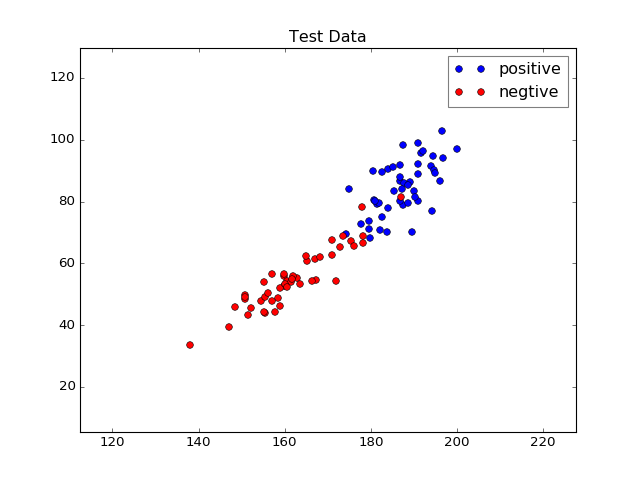

In [13]:
# plotting
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
X_t_ = np.vstack((x, y))  # only the measurements; data is col-wise
xmin, ymin = X_t_.min(axis=1)
xmax, ymax = X_t_.max(axis=1)

xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

plt_rex.plot2d(X_t_pos, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
              show=False, axs=axs, set_aspect_equal=False, plotlabel="positive")
plt_rex.plot2d(X_t_neg, colwise_data=True, hatch='ro', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, set_aspect_equal=False, 
               plotlabel="negtive", title="Test Data")

In [14]:
print(X.shape[1])
hit=0
for i in range(X_t.shape[1]):
#     print("=====")
#     print(i)
#     print(X_t[0:2,i])
    inds = k_nearest_neighbors_smallk(X[0:2,:],X_t[0:2,i],3)
    #Alternative inds = k_nearest_neighbors(X_[0:2,:],X[0:2,i],5)
#     print(inds)
#     print(X[2,inds])
#     print(np.sum(X[2,inds]))
#     print(X_t[2,i])
    #check if prediction (np.sum(X[2,inds])) matches the true lable (X_t[2,i])
#     print( np.multiply(np.sum(X[2,inds]),X_t[2,i]) )
    if np.multiply(np.sum(X[2,inds]),X_t[2,i])>0:
        hit+=1

print(hit)
print(X_t.shape[1])
print(hit/X_t.shape[1])

256
86
96
0.8958333333333334


In [15]:
def recoAccurKNN(train, test, k, method):
    hit=0
    for i in range(test.shape[1]):
#         print("=====")
#         print(i)
#         print(test[0:2,i])
#         inds = k_nearest_neighbors_smallk(train[0:2,:],test[0:2,i],k)
        if method==0:
            inds = k_nearest_neighbors(train[0:2,:],test[0:2,i],k)
        elif method==1:
            inds = k_nearest_neighbors_smallk(train[0:2,:],test[0:2,i],k)
        elif method==2:
            inds = k_nearest_neighbors_par(train[0:2,:],test[0:2,i],k)

#         print(inds)
#         print(train[2,inds])
#         print(np.sum(train[2,inds]))
#         print(test[2,i])
#         check if prediction (np.sum(train[2,inds])) matches the true lable (test[2,i])
#         print( np.multiply(np.sum(train[2,inds]),test[2,i]) )
        if np.multiply(np.sum(train[2,inds]),test[2,i])>0:
            hit+=1
    return (hit/test.shape[1])

In [ ]:
i=1
while i<=21:
    for j in range(3):
        start = timeit.default_timer()
        for k in range(100):
            reco = recoAccurKNN(X,X_t,i,j)
        stop = timeit.default_timer()
        print("Rate on k =",i,", method =",j,":",reco," Time:",stop-start)
    i+=2

#Speed up using method 2.

Rate on k = 1 , method = 0 : 0.8854166666666666  Time: 0.34412380601861514
Rate on k = 1 , method = 1 : 0.8854166666666666  Time: 0.3839764310105238
Rate on k = 1 , method = 2 : 0.8854166666666666  Time: 0.267593467986444
Rate on k = 3 , method = 0 : 0.8958333333333334  Time: 0.3283910019963514
Rate on k = 3 , method = 1 : 0.8958333333333334  Time: 1.0431846609862987
Rate on k = 3 , method = 2 : 0.8958333333333334  Time: 0.24583800398977473
Rate on k = 5 , method = 0 : 0.9375  Time: 0.31363271301961504
Rate on k = 5 , method = 1 : 0.9375  Time: 1.6213469920039643
Rate on k = 5 , method = 2 : 0.9375  Time: 0.2664794989977963
Rate on k = 7 , method = 0 : 0.9166666666666666  Time: 0.34904568101046607
Rate on k = 7 , method = 1 : 0.9270833333333334  Time: 2.395506945991656
Rate on k = 7 , method = 2 : 0.9166666666666666  Time: 0.2738714489969425
Rate on k = 9 , method = 0 : 0.9270833333333334  Time: 0.32704422998358496
Rate on k = 9 , method = 1 : 0.9270833333333334  Time: 2.95027324900729

In [17]:
def test1NNtime(data, method):
    start = timeit.default_timer()
    for i in range(data.shape[1]):
#         print("=====")
#         print(i)
#         print(data[0:2,i])
        data_=np.delete(data, i, axis=1)##Delete itself
        if method==1:
            inds = nearest_neighbor_method1(data_[0:2,:],data[0:2,i])
        elif method==2:
            inds = nearest_neighbor_method2(data_[0:2,:],data[0:2,i])
        elif method==3:
            inds = nearest_neighbor_method3(data_[0:2,:],data[0:2,i])
#         print(inds)
#         print(data[0:2,inds])
    stop = timeit.default_timer()
    return (stop-start)


In [18]:
print("Time for method 1: ",test1NNtime(X_t,1))

print("Time for method 2: ",test1NNtime(X_t,2))

print("Time for method 3: ",test1NNtime(X_t,3))


Time for method 1:  0.09556329797487706
Time for method 2:  0.003694997983984649
Time for method 3:  0.0023207170015666634


In [19]:
print( k_nearest_neighbors(X[0:2,:],X_t[0:2,i],5) )
print( k_nearest_neighbors_smallk(X[0:2,:],X_t[0:2,i],5) )
print( k_nearest_neighbors_par(X[0:2,:],X_t[0:2,i],5))

[ 27  17  44  64 120]
[ 27  17  42  61 116]
[ 44  27  17  64 120]


In [20]:
# print(X)
q = np.array([170, 66])
k=3

In = X[0:2,:].T
sorted_inds = np.argsort(np.sum((In - q)**2, axis=1))
print(sorted_inds)
print(sorted_inds[:k])
In=X[0:2,:].T
sorted_inds = np.argpartition(np.sum((In - q)**2, axis=1), k-1, axis=-1, kind='introselect', order=None)
print(sorted_inds)
print(sorted_inds[:k])


[101 183  63 205 231 141 137 251 242 159 165 221 188 225 174 208 214 198
 247 195 197 116 140 128 246 235 144 211 226 172 199  41 106 180 142 229
 136 157 217 245  91 194  10 127  96 145 123  22  67 110 121  47 130 236
 151 212 152 255  65   9 150 178 239 249 131 181 154 134 114 241 139  98
  40  14 185 103 218 132  86 224 126  68 138  38 192  31  71 162   1   3
 164 196  58 200 230 219  82 252  49 146  60 206 168  76  50  92 113 209
 216 203  12   7  69 148  51  46 117 173  11  99 253 105  95  18 233  36
 243 237 100  81 147 222  53  57 240 215 228  73 189   8  42  84  87  62
 112 187  74 104 254  13  37 124 158 119 234   6 201 177  75 167 191  83
  77  28  32 238  70 122  56 143 133 204 160  35 244 220  61 155  20 166
 210 118 125  52  24  79 207  66  80  48   2 176  33 193 227  23 120 153
  26 248 232  17  45  55 107  97 213  78  64  59  85  44 149 170 102  54
  27 190 129 108 223  30 156 202   5 184  72 186  93  43   0  39  19   4
 109  16 169  88  15  89 171  94  21  25 179 163 16